In [1]:
import QNN as qnn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import os

2024-10-02 08:03:41.595583: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 08:03:41.595596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 08:03:41.596180: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1 Physical GPUs, 1 Logical GPUs


In [2]:
def f1(x, eps=0.0):
    """The function f(x)= |x| + noise"""
    return np.abs(x) + eps * np.random.normal(size=x.shape)


def f2(x, eps=0.0):
    """The function f(x)=sin(x) + noise"""
    return np.sin(x) + eps * np.random.normal(size=x.shape)


def f3(x, eps=0.0):
    """The function f(x)=exp(x)+noise"""
    return np.exp(x) + eps * np.random.normal(size=x.shape)


def f4(x, eps=0.0):
    """The function f(x)=log(x+2*pi)+noise"""
    return np.log(x+2*np.pi) + eps * np.random.normal(size=x.shape)


def f5(x, eps=0.0):
    """The function f(x)=x^3+noise"""
    return x**3 + eps * np.random.normal(size=x.shape)


def f6(x, eps=0.0):
    """The function f(x)=x^3+noise"""
    return np.exp(-(x**2)/2) + eps * np.random.normal(size=x.shape)

In [3]:
# Prepare your dataset
x = np.linspace(-np.pi, np.pi, 300).reshape(-1, 1)
F = [f1, f2, f3, f4, f5]
Y = np.array([f(x, eps=0.1) for f in F])

def min_max_normalize(data):
    min_val = data.min(axis=1, keepdims=True)
    max_val = data.max(axis=1, keepdims=True)
    return (data - min_val) / (max_val - min_val)

# Normalize each result individually
Y = min_max_normalize(Y)

In [ ]:
# Train the model
results = []
layers = [6]*6
for i in range(6):
    results.append(qnn.train_model(x, Y[i], i+1, num_layers=layers[i], cutoff_dim=10, epochs=500, non_gaussian='cubicphase', rec=True))
H, M = zip(*results)

In [ ]:
fit = plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

Y_preds = [model.predict(x, verbose = 0) for model in M]
y_labels = [
    r'$f(x) = |x| + \text{noise}$',
    r'$f(x) = \sin(x) + \text{noise}$',
    r'$f(x) = \exp(x) + \text{noise}$',
    r'$f(x) = \log(x+2\pi) + \text{noise}$',
    r'$f(x) = x^3 + \text{noise}$',
    r'$f(x) = \exp(x^2/2) + \text{noise}$'
]

for i in range(6):
    ax = fit.add_subplot(gs[i // 3, i % 3])
    y = Y[i]
    y_pred = Y_preds[i]
    ax.scatter(x, y, s=5, label="Noisy Data")
    ax.plot(x, y_pred, label='Fitted Curve', color='r')
    ax.set_title(f'Data fit {i+1}')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(y_labels[i])
    ax.legend(fontsize='x-small')
    ax.set_box_aspect(1)

plt.tight_layout()
fit.savefig('fits.png')
plt.show()

In [ ]:
# Loss plot
cost = plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

for i in range(6):
    ax = plt.subplot(gs[i // 3, i % 3])
    ax.plot(H[i]['loss'], label='Training Loss')
    ax.plot(H[i]['val_loss'], label='Validation Loss')
    ax.set_title("Losses for: " + y_labels[i])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_ybound(0.0, 0.01)
    ax.legend(fontsize='x-small')
    ax.set_box_aspect(1)

plt.tight_layout()
cost.savefig('mse_with_val.png')
plt.show()

In [ ]:
# R2 score plot
r2 = plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

for i in range(6):
    ax = plt.subplot(gs[i // 3, i % 3])
    ax.plot(H[i]['r2_score'], label='Training R2 Score')
    ax.plot(H[i]['val_r2_score'], label='Validation R2 Score')
    ax.set_title("R2 Scores for: " + y_labels[i])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('R2 Score')
    ax.set_ybound(0.8, 1.01)
    ax.axhline(y=1.0, color='b', linestyle='--')
    ax.axhline(y=0.9, color='r', linestyle='--')
    ax.legend(fontsize='x-small')
    ax.set_box_aspect(1)

plt.tight_layout()
r2.savefig('r2_with_val.png')
plt.show()

In [21]:
# Save the history
def numpy_array_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: numpy_array_to_list(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [numpy_array_to_list(item) for item in obj]
    return obj

In [ ]:
# Save each dictionary to a separate JSON file
for i, dictionary in enumerate(H):
    filename = f"H{i}.json"
    with open(filename, 'w') as file:
        # Convert NumPy arrays to lists before JSON serialization
        json_serializable_dict = numpy_array_to_list(dictionary)
        json.dump(json_serializable_dict, file, indent=4)

print("All dictionaries have been saved to JSON files.")

In [ ]:
# Train the model
classical_results = []
layers = [6]*6
for i in range(6):
    classical_results.append(qnn.train_classical_model(x, Y[i], i+1, learning_rate=0.01, num_layers=layers[i], non_linearity='cubicphase', epochs=500))
cH, cM = zip(*classical_results)

In [ ]:
for i in range(6):
    cM[i].save(f'cM{i}.keras')

# Save the history
for i, dictionary in enumerate(cH):
    filename = f"cH{i}.json"
    with open(filename, 'w') as file:
        # Convert NumPy arrays to lists before JSON serialization
        json_serializable_dict = numpy_array_to_list(dictionary)
        json.dump(json_serializable_dict, file, indent=4)

print("All dictionaries have been saved to JSON files.")

In [ ]:
cfit = plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

Yc_preds = [model.predict(x, verbose = 0) for model in cM]
y_labels = [
    r'$f(x) = |x| + \text{noise}$',
    r'$f(x) = \sin(x) + \text{noise}$',
    r'$f(x) = \exp(x) + \text{noise}$',
    r'$f(x) = \log(x+2\pi) + \text{noise}$',
    r'$f(x) = x^3 + \text{noise}$',
    r'$f(x) = \exp(x^2/2) + \text{noise}$'
]

for i in range(6):
    ax = cfit.add_subplot(gs[i // 3, i % 3])
    y = Y[i]
    y_pred = Yc_preds[i]
    ax.scatter(x, y, s=5, label="Noisy Data")
    ax.plot(x, y_pred, label='Fitted Curve', color='r')
    ax.set_title(f'Data fit {i+1}')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(y_labels[i])
    ax.legend(fontsize='x-small')
    ax.set_box_aspect(1)

plt.tight_layout()
cfit.savefig('fits_classical.png')
plt.show()

In [ ]:
# Loss plot
ccost = plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

for i in range(6):
    ax = plt.subplot(gs[i // 3, i % 3])
    ax.plot(cH[i]['loss'], label='Training Loss')
    ax.plot(cH[i]['val_loss'], label='Validation Loss')
    ax.set_title("Losses for: " + y_labels[i])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_ybound(0.0, 0.02)
    ax.legend(fontsize='x-small')
    ax.set_box_aspect(1)

plt.tight_layout()
ccost.savefig('mse_with_val_classical.png')
plt.show()

In [ ]:
# R2 score plot
cr2 = plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

for i in range(6):
    ax = plt.subplot(gs[i // 3, i % 3])
    ax.plot(cH[i]['r2_score'], label='Training R2 Score')
    ax.plot(cH[i]['val_r2_score'], label='Validation R2 Score')
    ax.set_title("R2 Scores for: " + y_labels[i])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('R2 Score')
    ax.set_ybound(0.65, 1.01)
    ax.axhline(y=1.0, color='b', linestyle='--')
    ax.axhline(y=0.9, color='r', linestyle='--')
    ax.legend(fontsize='x-small')
    ax.set_box_aspect(1)

plt.tight_layout()
cr2.savefig('r2_with_val_classical.png')
plt.show()

In [ ]:
r2_cf = plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

for i in range(6):
    ax = plt.subplot(gs[i // 3, i % 3])    
    ax.plot(H[i]['r2_score'], label='QNN Training R2')
    ax.plot(H[i]['val_r2_score'], label='QNN Validation R2 Score')
    ax.plot(cH[i]['r2_score'], label='ANN Training R2 Score', ls='--')
    ax.plot(cH[i]['val_r2_score'], label='ANN Validation R2 Score', ls='--')
    ax.set_title("R2 Scores for: " + y_labels[i])
    ax.set_xlabel('Epochs') 
    ax.set_ylabel('R2 Score')
    ax.set_ybound(0.6,1.01)
    ax.legend()
    ax.set_box_aspect(1)

plt.tight_layout()
r2_cf.savefig('r2_comparison.png')
plt.show()

In [8]:
# Train the model
LH = []
layers = [1,2,3,4,5]
for nums in layers:
    LH.append(qnn.train_model(x, Y[1], 0, learning_rate=0.01, num_layers=nums, cutoff_dim=10, epochs=500, rec=False)[0])

# Save each dictionary to a separate JSON file
for i, dictionary in enumerate(LH):
    filename = f"LH{i}.json"
    with open(filename, 'w') as file:
        # Convert NumPy arrays to lists before JSON serialization
        json_serializable_dict = numpy_array_to_list(dictionary)
        json.dump(json_serializable_dict, file, indent=4)

print("All dictionaries have been saved to JSON files.")

Fold 5 complete.
Cross-validation complete.
Best model from fold 2
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 QuantumEncoding (QEncoder)  (None, 10, 1)             0         
                                                                 
 QuantumLayer_1 (QLayer)     (None, 10, 1)             6         
                                                                 
 QuantumLayer_2 (QLayer)     (None, 10, 1)             6         
                                                                 
 QuantumLayer_3 (QLayer)     (None, 10, 1)             6         
                                                                 
 QuantumLayer_4 (QLayer)     (None, 10, 1)             6         
                                                                 
 QuantumLayer_5 (QLayer)     (None, 10, 1)             6         
                                                    

In [ ]:
DH = []
dims = [5,10,12,15,20]
for cutoff in dims:
    DH.append(qnn.train_model(x, Y[1], 1, learning_rate=0.01, num_layers=6, cutoff_dim=cutoff, epochs=500, rec=False)[0])

# Save each dictionary to a separate JSON file
for i, dictionary in enumerate(DH):
    filename = f"DH{i}.json"
    with open(filename, 'w') as file:
        # Convert NumPy arrays to lists before JSON serialization
        json_serializable_dict = numpy_array_to_list(dictionary)
        json.dump(json_serializable_dict, file, indent=4)

print("All dictionaries have been saved to JSON files.")

In [39]:
# Initialize an empty list to store the data from each file
LH = []
DH = []
cLH = []
# Define the directory path
directory = "Model Histories/Sine Comparison"

# Iterate through the files
for i in range(5):  # 0 to 4
    lh_filename = f"LH{i}.json"  # Adjust the filename pattern if needed
    lh_filepath = os.path.join(directory, lh_filename)
    
    # Open and read the JSON file
    with open(lh_filepath, 'r') as file:
        lh_data = json.load(file)
    
    # Convert each list in the JSON to a NumPy array
    lh_numpy_data = {key: np.array(value) for key, value in lh_data.items()}
    
    # Append the converted data to H
    LH.append(lh_numpy_data)

    dh_filename = f"DH{i}.json"
    dh_filepath = os.path.join(directory, dh_filename)
    
    with open(dh_filepath, 'r') as file:
        dh_data = json.load(file)
    
    # Convert each list in the JSON to a NumPy array
    dh_numpy_data = {key: np.array(value) for key, value in dh_data.items()}
    
    # Append the converted data to cLH
    DH.append(dh_numpy_data)

    cLH_filename = f"cLH{i}.json"
    cLH_filepath = os.path.join(directory, cLH_filename)
    
    with open(dh_filepath, 'r') as file:
        cLH_data = json.load(file)
    
    # Convert each list in the JSON to a NumPy array
    cLH_numpy_data = {key: np.array(value) for key, value in cLH_data.items()}
    
    # Append the converted data to DH
    cLH.append(cLH_numpy_data)

In [40]:
dims = [5,10,12,15,20]
layers = [1,2,3,4,5]

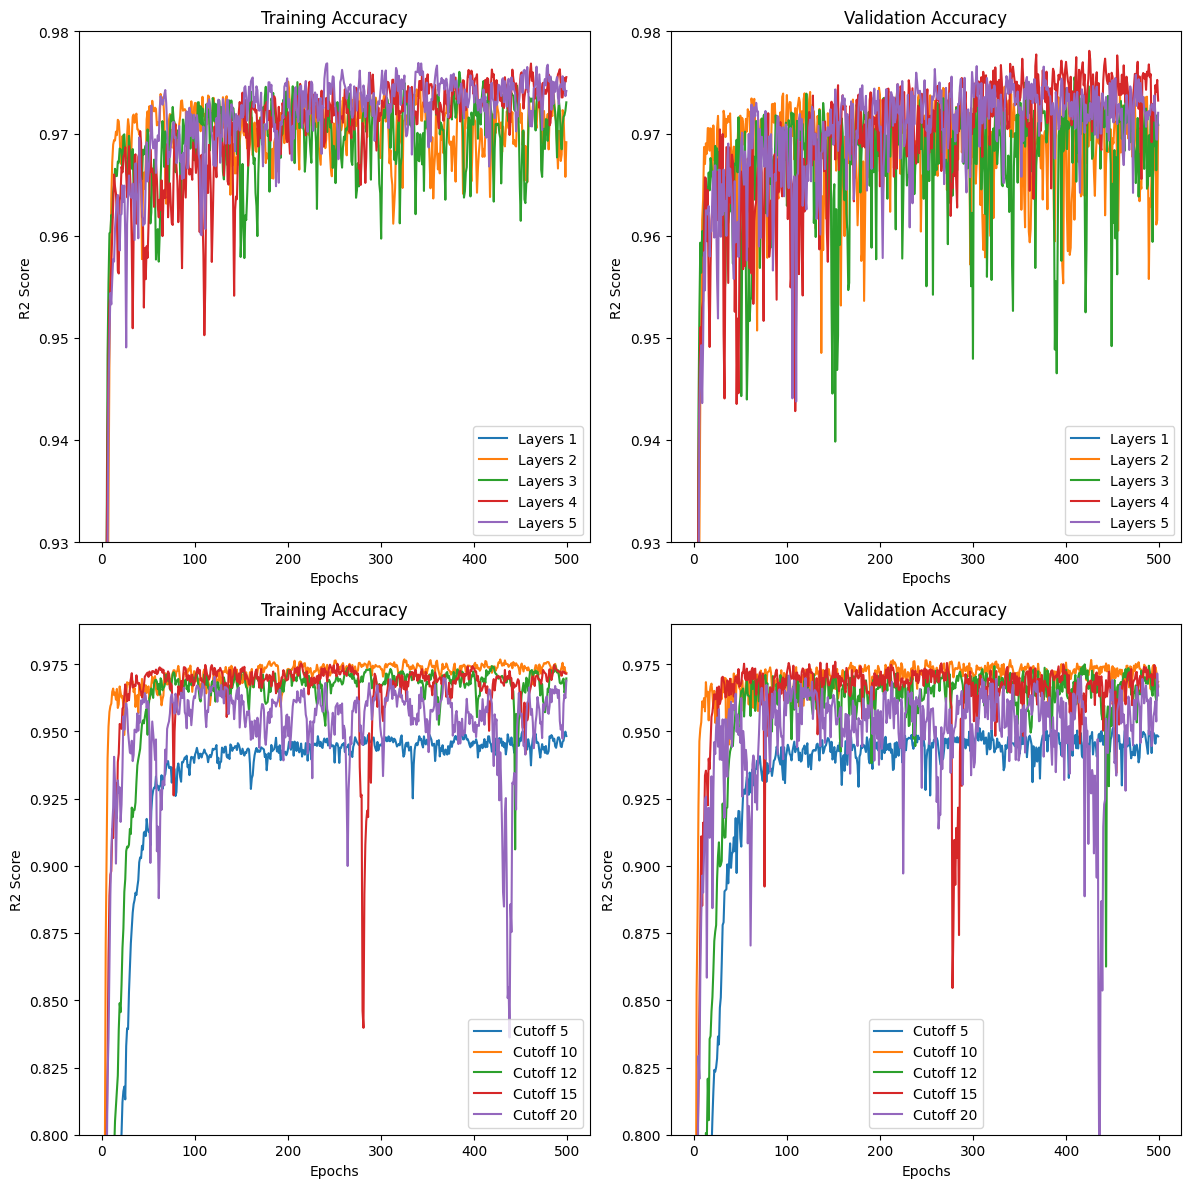

In [41]:
vars = plt.figure(figsize=(12, 12))
gs = plt.GridSpec(2, 2)

# Lists and keys to plot
history_dict = [
    (LH, 'r2_score'),
    (LH, 'val_r2_score'),
    (DH, 'r2_score'),
    (DH, 'val_r2_score')
]

# Create 4 subplots
for i, (data_list, key) in enumerate(history_dict):
    ax = vars.add_subplot(gs[i // 2, i % 2])
    
    # Plot all objects from the list
    for history in data_list:
        ax.plot(history[key])
    
    ax.set_title("Training Accuracy" if i % 2 == 0 else "Validation Accuracy")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('R2 Score')
    ax.legend([f'Layers {L}' if i < 2 else f'Cutoff {D}' for L, D in zip(layers, dims)])
    if i < 2:
        ax.set_ybound(0.93,0.98)
    else:
        ax.set_ybound(0.80,0.99)
    ax.set_box_aspect(1)

plt.tight_layout()
#vars.savefig('variations.png')
plt.show()

In [4]:
# Train the model
cLH = []
new_layers = [1,2,3,4,5]
for nums in new_layers:
    cLH.append(qnn.train_classical_model(x, Y[1], 1, learning_rate=0.01, num_layers=nums, epochs=500)[0])

Fold 5 complete.
Cross-validation complete.
Best model from fold 3
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cp_layer_60 (CPLayer)       (None, 2)                 6         
                                                                 
 cp_layer_61 (CPLayer)       (None, 2)                 6         
                                                                 
 cp_layer_62 (CPLayer)       (None, 2)                 6         
                                                                 
 cp_layer_63 (CPLayer)       (None, 2)                 6         
                                                                 
 cp_layer_64 (CPLayer)       (None, 2)                 6         
                                                                 
 extract_x_layer_22 (Extrac  (None, 1)                 0         
 tXLayer)                                           

In [22]:
# Save each dictionary to a separate JSON file
for i, dictionary in enumerate(cLH):
    filename = f"cLH{i}.json"
    with open(filename, 'w') as file:
        # Convert NumPy arrays to lists before JSON serialization
        json_serializable_dict = numpy_array_to_list(dictionary)
        json.dump(json_serializable_dict, file, indent=4)

print("All dictionaries have been saved to JSON files.")

All dictionaries have been saved to JSON files.


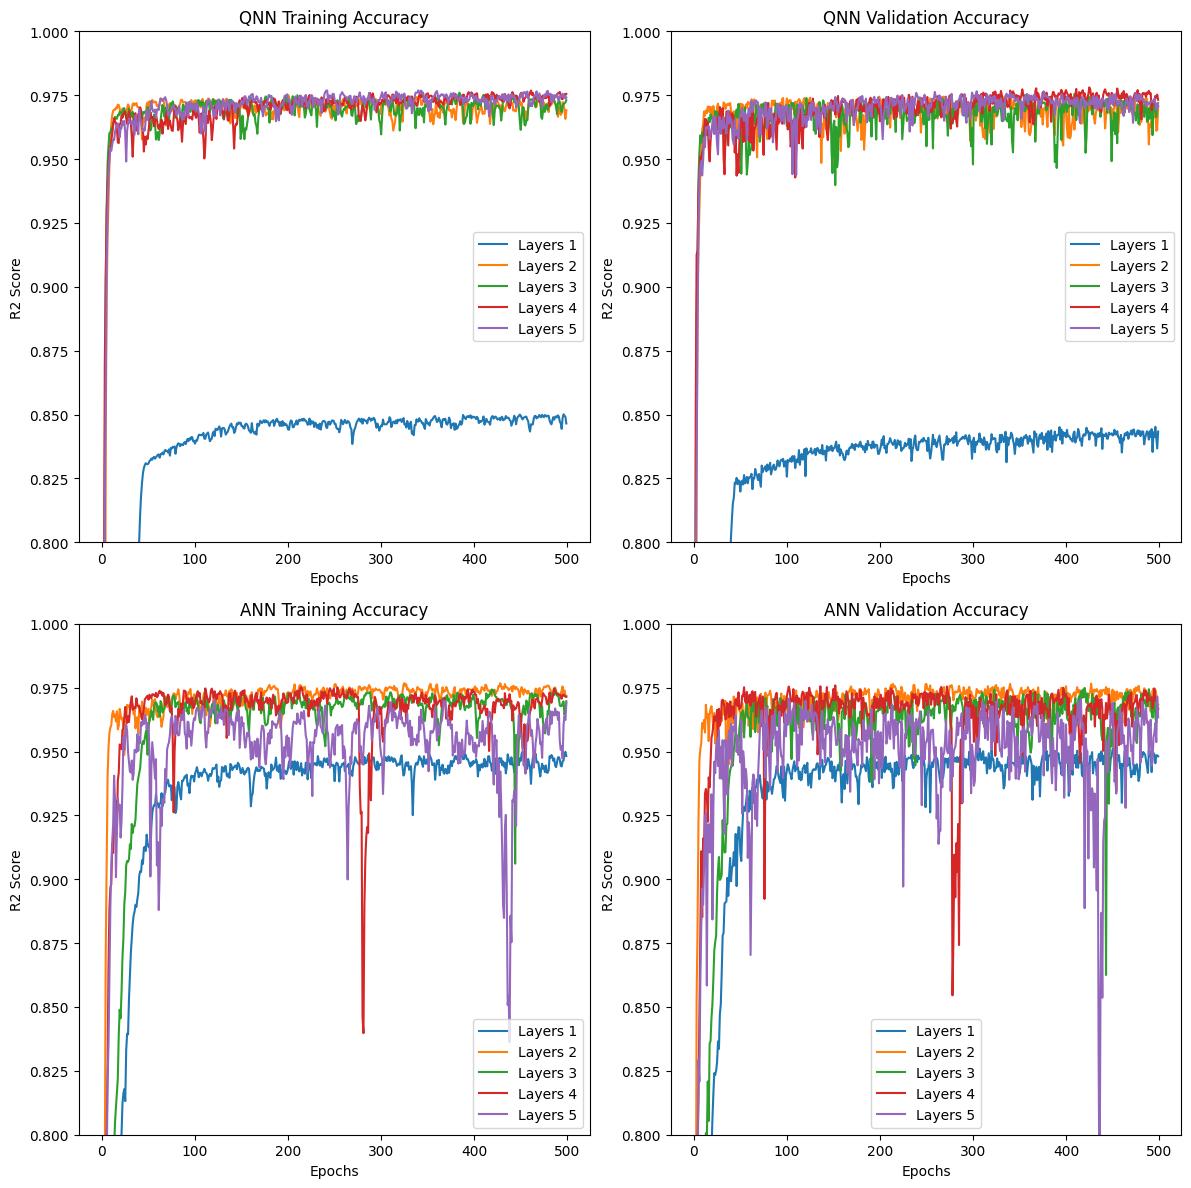

In [42]:
from cycler import cycler

# Define the specific colors for layers 1 through 5
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
custom_cycler = cycler(color=colors)

cfs = plt.figure(figsize=(12, 12))
gs = plt.GridSpec(2, 2)

# Lists and keys to plot
history_dict = [
    (LH, 'r2_score'),
    (LH, 'val_r2_score'),
    (cLH, 'r2_score'),
    (cLH, 'val_r2_score')
]
nets = ['QNN', 'QNN', 'ANN', 'ANN']

# Create 4 subplots
for i, (data_list, key) in enumerate(history_dict):
    ax = cfs.add_subplot(gs[i // 2, i % 2])
    ax.set_prop_cycle(custom_cycler)  # Set the color cycle for each subplot
    
    # Plot all objects from the list
    for history in data_list:
        ax.plot(history[key])
    
    ax.set_title(f'{nets[i]} Training Accuracy' if i % 2 == 0 else f'{nets[i]} Validation Accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('R2 Score')
    ax.legend([f'Layers {L}' for L in layers])
    
    if i < 2:
        ax.set_ybound(0.8, 1.0)
    else:
        ax.set_ybound(0.8, 1.0)
    
    ax.set_box_aspect(1)

plt.tight_layout()
cfs.savefig('comparisons.png')
plt.show()

In [2]:
import qutip as qt

state = qt.ghz_state()
state = state.full()
state = tf.cast(state, dtype=tf.complex64)

In [4]:
H, M = qnn.learn_state(state, learning_rate=0.05, std=0.1, num_layers=15, epochs=2500)

Epoch 1/2500


I0000 00:00:1727849065.755161 4046632 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 23s 23s/step - loss: 0.2934 - metric: 0.4993
Epoch 2/2500
1/1 [==============================] - 0s 46ms/step - loss: 0.7014 - metric: 0.0904
Epoch 3/2500
1/1 [==============================] - 0s 45ms/step - loss: 0.3110 - metric: 0.4754
Epoch 4/2500
1/1 [==============================] - 0s 44ms/step - loss: 0.3263 - metric: 0.4572
Epoch 5/2500
1/1 [==============================] - 0s 47ms/step - loss: 0.3514 - metric: 0.4473
Epoch 6/2500
1/1 [==============================] - 0s 51ms/step - loss: 0.3436 - metric: 0.4375
Epoch 7/2500
1/1 [==============================] - 0s 42ms/step - loss: 0.3986 - metric: 0.3716
Epoch 8/2500
1/1 [==============================] - 0s 45ms/step - loss: 0.3751 - metric: 0.4126
Epoch 9/2500
1/1 [==============================] - 0s 43ms/step - loss: 0.3377 - metric: 0.4630
Epoch 10/2500
1/1 [==============================] - 0s 48ms/step - loss: 0.3376 - metric: 0.4574
Epoch 11/2500
1/1 [=======================

In [7]:
M.predict(tf.reshape(qnn.get_vacuum_state_tf(8), [1,8,1]), verbose=0)

array([[[0.8224217 -0.00209224j],
        [0.00957458-0.00701383j],
        [0.00600181+0.01531054j],
        [0.01529133-0.02182829j],
        [0.0440205 -0.00631986j],
        [0.01711554-0.00769208j],
        [0.00731104-0.00867973j],
        [0.56150246-0.06893664j]]], dtype=complex64)